# Analysis of weather impact to human

### _Hung Dinh_
### _April 3, 2018_

# 1. Synopsis

This project focuses on data cleaning and some basic exploratory.

This data summarizes human damage in the USA by extreme weather conditions from 1950 to 2011. It contains loss information (fatalities, injuries, crops...) by weather events (flood, heat, hurricane...).

The data has more than 900,000 incidents with 55 weather types. It needs to be processed, especially to clean the “Event Types” variable because of typos and abbreviations. The original data can be found at: https://d396qusza40orc.cloudfront.net/repdata%2Fpeer2_doc%2Fpd01016005curr.pdf.

I have processed this variable thoroughly, particularly classified the variable from 985 down to 38 unique entries. I then look at the total human lost (health and economic problems) with respect to these 38 event types. After sorting the total lost, I make plots to see which events have most impact on the problems.

From this information we can examine different natural aspects toward human losts. The results help authorities to put different priorities if they want to prevent live lost or concentrate more on economic issues.

In [1]:
library(ggplot2)
library(gridExtra) # to make multiplots

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# 2. Data loading and refining

In [2]:
library("aws.s3")
obj <- get_object(
    object = "StormData.csv",
    bucket = "humanlossbyweatherevents-donotdelete-pr-don8rmzwrid2bl",
    key = "34497ccfb4b54b49b42f0026ad5e2c22",
    secret = "98d79c7d4627974a5fcb659e7cf7b607a7e2280a040e8bfb",
    check_region = FALSE,
    base_url = "s3-api.us-geo.objectstorage.service.networklayer.com")

In [3]:
dat <- read.csv(text = rawToChar(obj), na.strings = "NA")
str(dat)

'data.frame':	902297 obs. of  37 variables:
 $ STATE__   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ BGN_DATE  : Factor w/ 16335 levels "1/1/1966 0:00:00",..: 6523 6523 4242 11116 2224 2224 2260 383 3980 3980 ...
 $ BGN_TIME  : Factor w/ 3608 levels "00:00:00 AM",..: 272 287 2705 1683 2584 3186 242 1683 3186 3186 ...
 $ TIME_ZONE : Factor w/ 22 levels "ADT","AKS","AST",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ COUNTY    : num  97 3 57 89 43 77 9 123 125 57 ...
 $ COUNTYNAME: Factor w/ 29601 levels "","5NM E OF MACKINAC BRIDGE TO PRESQUE ISLE LT MI",..: 13513 1873 4598 10592 4372 10094 1973 23873 24418 4598 ...
 $ STATE     : Factor w/ 72 levels "AK","AL","AM",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ EVTYPE    : Factor w/ 985 levels "   HIGH SURF ADVISORY",..: 834 834 834 834 834 834 834 834 834 834 ...
 $ BGN_RANGE : num  0 0 0 0 0 0 0 0 0 0 ...
 $ BGN_AZI   : Factor w/ 35 levels "","  N"," NW",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ BGN_LOCATI: Factor w/ 54429 levels ""," Christiansburg",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ END_D

The data contains 902,297 observations with 37 variables. The weather event types are stored in `EVTYPE`. Their effects on public health and economy are stored in (`FATALITIES`, `INJURIES`) and (`PROPDMG`, `PROPDMGEXP`, `CROPDMG`, `CROPDMGEXP`), respectively.

Now I will extract only these useful information.

In [4]:
dat <- dat[,c(8,23:28)]

and can examine `EVTYPE`:

In [5]:
str(unique(dat$EVTYPE))

 Factor w/ 985 levels "   HIGH SURF ADVISORY",..: 834 856 244 201 629 429 657 972 409 786 ...


There are 985 types in `EVTYPE` with a lot of real life problems: typos (incorrect spelling), duplicates, non- or not-enough- information names.

# 3. Processing strategy

My strategy is to fix and re-classify these 985 types manually and thoroughly, according to my standard. Since this is a reproducible research, it is not necessary that you agree with my classification. Instead, I document my rationale and everything I have done so you can keep track.

Based on the official document, there are 55 official event types. I will group the `EVTYPE` of the 902,297 observations into 38 types, defined as below (where the listed types are original type names in the official document):

- **The 18 primary groups of serious events:**
    - FLOOD: Flood, Coastal Flood, Debris Flow, Flash Flood, Lakeshore Flood, Heavy Rain
    - HEAT: Heat, Exessive Heat
    - COLD: Frost/Freeze, Extreme Cold/Wind Chill, Cold/Wind Chill
    - AVALANCHE
    - BLIZZARD: Blizzard, Winter Storm
    - ICE: Ice Storm
    - HURRICANE (typhoon)
    - TORNADO
    - TROPICAL STORM - TSUNAMI
    - MARINE: 10 types reduced to 9 (merge High Wind and Strong Wind)

- **The 19 secondary groups of less serious events:**
    - WIND: High Wind, Strong Wind
    - SNOW: Heavy Snow, Sleet, Lake-effect Snow
    - TIDE WAVE: High Surf, Sneaker Wave
    - ASTRONOMICAL LOW TIDE
    - FOG: Dense Fog, Freezing Fog
    - SMOKE: Dense Smoke, Volcanic Ash
    - DROUGHT
    - DUST: Dust Devil, Dust Storm
    - FUNNEL CLOUD
    - HAIL
    - LIGHTNING
    - RIP CURRENT
    - SEICHE
    - THUNDERSTORM WIND
    - STORM SURGE/TIDE
    - TROPICAL DEPRESSION
    - WATERSPOUT
    - WILDFIRE
    - WINTER WEATHER

- **The last event group is named _OTHER_ for all remaining or unclassifiable types.**

I will reassign them (no case sensitive) to `EVTYPE` of every observables. The ones which do not fall into any of the primary and secondary types are marked _OTHER_.

There are some with 2 or 3 types together, eg: FLASH FLOODING/THUNDERSTORM WIND, the primaries will be selected (FLASH FLOODING). If the types are in the same level (primary/secondary), eg: HEAVY SNOW/WIND, the first one will be selected (HEAVY SNOW).

# 4. Data cleaning

I first store 902,297 `EVTYPE` observations to a new array **evtypes** and their unique 985 values to a new array **evname**:

In [6]:
evnames <- as.character(unique(dat$EVTYPE))
evtypes <- as.character(dat$EVTYPE)

## 4.1. Serious events

Now for example, if I first want to group Flood, Coastal Flood, Debris Flow, Flash Flood, Lakeshore Flood into the main group `FLOOD` (Heavy Rain will be processed later), I find all `EVTYPE`s that contain the string “FLOOD” and store their index into variable `idx`:

In [7]:
evnames[grep('FLOOD', ignore.case = TRUE, evnames)]

[1] "ICE STORM/FLASH FLOOD"          "FLASH FLOOD"                   
  [3] "FLASH FLOODING"                 "FLOODING"                      
  [5] "FLOOD"                          "FLASH FLOODING/THUNDERSTORM WI"
  [7] "BREAKUP FLOODING"               "RIVER FLOOD"                   
  [9] "COASTAL FLOOD"                  "FLOOD WATCH/"                  
 [11] "FLASH FLOODS"                   "FLOODING/HEAVY RAIN"           
 [13] "HEAVY SURF COASTAL FLOODING"    "URBAN FLOODING"                
 [15] "URBAN/SMALL FLOODING"           "LOCAL FLOOD"                   
 [17] "FLOOD/FLASH FLOOD"              "FLOOD/RAIN/WINDS"              
 [19] "FLASH FLOOD WINDS"              "URBAN/SMALL STREAM FLOODING"   
 [21] "STREAM FLOODING"                "FLASH FLOOD/"                  
 [23] "FLOOD/RAIN/WIND"                "SMALL STREAM URBAN FLOOD"      
 [25] "URBAN FLOOD"                    "HEAVY RAIN/FLOODING"           
 [27] "COASTAL FLOODING"               "HIGH WINDS/FLOODING"           
 [29] "URBAN/SMALL STREAM FLOOD"       "MINOR FLOODING"                
 [31] "URBAN/SMALL STREAM  FLOOD"      "URBAN AND SMALL STREAM FLOOD"  
 [33] "SMALL STREAM FLOODING"          "FLOODS"                        
 [35] "SMALL STREAM AND URBAN FLOODIN" "SMALL STREAM/URBAN FLOOD"      
 [37] "SMALL STREAM AND URBAN FLOOD"   "RURAL FLOOD"                   
 [39] "THUNDERSTORM WINDS URBAN FLOOD" "MAJOR FLOOD"                   
 [41] "ICE JAM FLOODING"               "STREET FLOOD"                  
 [43] "SMALL STREAM FLOOD"             "LAKE FLOOD"                    
 [45] "URBAN AND SMALL STREAM FLOODIN" "RIVER AND STREAM FLOOD"        
 [47] "MINOR FLOOD"                    "HIGH WINDS/COASTAL FLOOD"      
 [49] "RIVER FLOODING"                 "FLOOD/RIVER FLOOD"             
 [51] "MUD SLIDES URBAN FLOODING"      "HEAVY SNOW/HIGH WINDS & FLOOD" 
 [53] "HAIL FLOODING"                  "THUNDERSTORM WINDS/FLASH FLOOD"
 [55] "HEAVY RAIN AND FLOOD"           "LOCAL FLASH FLOOD"             
 [57] "FLOOD/FLASH FLOODING"           "COASTAL/TIDAL FLOOD"           
 [59] "FLASH FLOOD/FLOOD"              "FLASH FLOOD FROM ICE JAMS"     
 [61] "FLASH FLOOD - HEAVY RAIN"       "FLASH FLOOD/ STREET"           
 [63] "FLASH FLOOD/HEAVY RAIN"         "HEAVY RAIN; URBAN FLOOD WINDS;"
 [65] "FLOOD FLASH"                    "FLOOD FLOOD/FLASH"             
 [67] "TIDAL FLOOD"                    "FLOOD/FLASH"                   
 [69] "HEAVY RAINS/FLOODING"           "THUNDERSTORM WINDS/FLOODING"   
 [71] "HIGHWAY FLOODING"               "FLASH FLOOD/ FLOOD"            
 [73] "HEAVY RAIN/MUDSLIDES/FLOOD"     "BEACH EROSION/COASTAL FLOOD"   
 [75] "SNOWMELT FLOODING"              "FLASH FLOODING/FLOOD"          
 [77] "BEACH FLOOD"                    "THUNDERSTORM WINDS/ FLOOD"     
 [79] "FLOOD & HEAVY RAIN"             "FLOOD/FLASHFLOOD"              
 [81] "URBAN SMALL STREAM FLOOD"       "URBAN FLOOD LANDSLIDE"         
 [83] "URBAN FLOODS"                   "HEAVY RAIN/URBAN FLOOD"        
 [85] "FLASH FLOOD/LANDSLIDE"          "LANDSLIDE/URBAN FLOOD"         
 [87] "FLASH FLOOD LANDSLIDES"         "Minor Flooding"                
 [89] "Ice jam flood (minor"           "Coastal Flooding"              
 [91] "COASTALFLOOD"                   "Erosion/Cstl Flood"            
 [93] "Tidal Flooding"                 "River Flooding"                
 [95] "Flood/Flash Flood"              "STREET FLOODING"               
 [97] "Flood"                          "TIDAL FLOODING"                
 [99] " COASTAL FLOOD"                 "Urban Flooding"                
[101] "Urban flood"                    "Urban Flood"                   
[103] "Coastal Flood"                  "coastal flooding"              
[105] "Flood/Strong Wind"              "COASTAL FLOODING/EROSION"      
[107] "URBAN/STREET FLOODING"          "COASTAL  FLOODING/EROSION"     
[109] "FLOOD/FLASH/FLOOD"              " FLASH FLOOD"                  
[111] "CSTL FLOODING/EROSION"          "LA

In [8]:
idx <- grep('FLOOD', ignore.case = TRUE, evnames)

The code will list all `EVTYPE`s with “FLOOD” in them, I then look at each of them and classify each of them into “FLOOD” by their indexes.

After finding which entry belongs to the group, I replace all of `EVTYPE` observations with the matched `idx`, and update the unique list of their names:

In [9]:
evtypes[evtypes %in% evnames[idx]] <- 'FLOOD'
evnames[idx] <- 'FLOOD'

I can do the same thing with the next big group HEAT (not displaying match results):

In [10]:
idx <- grep('HEAT', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'HEAT'
evnames[idx] <- 'HEAT'

For the next group COLD, I look for string “FRO”, “FRE”, “COLD” (to account for typos):

In [11]:
evnames[grep('FRO|FRE|COLD', ignore.case = TRUE, evnames)]

[1] "FREEZING RAIN"                  "RECORD COLD"                   
 [3] "COLD"                           "EXTREME COLD"                  
 [5] "FREEZE"                         "HIGH WIND/BLIZZARD/FREEZING RA"
 [7] "RECORD COLD AND HIGH WIND"      "HEAVY SNOW/HIGH WINDS/FREEZING"
 [9] "FREEZING DRIZZLE"               "FREEZING RAIN AND SLEET"       
[11] "UNSEASONABLY COLD"              "EXTREME/RECORD COLD"           
[13] "DAMAGING FREEZE"                "FROST"                         
[15] "FREEZING RAIN/SNOW"             "SNOW/SLEET/FREEZING RAIN"      
[17] "SEVERE COLD"                    "COLD WAVE"                     
[19] "COLD AND WET CONDITIONS"        "COLD AIR FUNNEL"               
[21] "COLD AIR FUNNELS"               "FREEZING RAIN/SLEET"           
[23] "COLD AIR TORNADO"               "PROLONG COLD"                  
[25] "AGRICULTURAL FREEZE"            "BLIZZARD/FREEZING RAIN"        
[27] "HEAVY SNOW/FREEZING RAIN"       "FROST\\FREEZE"                 
[29] "HARD FREEZE"                    "FOG AND COLD TEMPERATURES"     
[31] "SNOW/COLD"                      "SNOW FREEZING RAIN"            
[33] "SNOW/FREEZING RAIN"             "HEAVY SNOW   FREEZING RAIN"    
[35] "RECORD COLD/FROST"              "FREEZING RAIN AND SNOW"        
[37] "FREEZING RAIN SLEET AND"        "FREEZING DRIZZLE AND FREEZING" 
[39] "RECORD SNOW/COLD"               "FREEZING RAIN SLEET AND LIGHT" 
[41] "SLEET & FREEZING RAIN"          "HIGH WINDS/COLD"               
[43] "COLD/WINDS"                     "SNOW/ BITTER COLD"             
[45] "COLD WEATHER"                   "EARLY FREEZE"                  
[47] "EARLY FROST"                    "SNOW AND COLD"                 
[49] "PROLONG COLD/SNOW"              "SNOW\\COLD"                    
[51] "Freeze"                         "Damaging Freeze"               
[53] "Unseasonable Cold"              "Early Frost"                   
[55] "Record Cold"                    "Extreme Cold"                  
[57] "Excessive Cold"                 "Freezing Rain"                 
[59] "Extended Cold"                  "Freezing Fog"                  
[61] "Freezing Spray"                 "Cold"                          
[63] "Freezing Drizzle"               "Cold Temperature"              
[65] "COLD AND SNOW"                  "SLEET/FREEZING RAIN"           
[67] "Frost"                          "Frost/Freeze"                  
[69] "Prolong Cold"                   "Cold and Frost"                
[71] "LATE FREEZE"                    "Freezing rain"                 
[73] "Freezing drizzle"               "COLD AND FROST"                
[75] "COLD TEMPERATURES"              "COLD WIND CHILL TEMPERATURES"  
[77] "FIRST FROST"                    "LIGHT SNOW/FREEZING PRECIP"    
[79] "FREEZING FOG"                   "RECORD  COLD"                  
[81] "LIGHT FREEZING RAIN"            "UNUSUALLY COLD"                
[83] "FROST/FREEZE"                   "EXTREME COLD/WIND CHILL"       
[85] "COLD/WIND CHILL"

In [12]:
idx <- grep('FRO|FRE|COLD', ignore.case = TRUE, evnames)

I found that not all of them can be put in COLD, eg. the 6th element HIGH WIND/BLIZZARD/FREEZING RAIN, it must go to group BLIZZARD. I can manually put that element to group BLIZZARD and put the remaining to COLD. In this example, I only put the remaining to COLD because I will process group BLIZZARD later.

In [13]:
evtypes[evtypes %in% evnames[idx[c(1:5,7:15,17:19,24:25,27:85)]]] <- 'COLD'
evnames[idx[c(1:5,7:15,17:19,24:25,27:85)]] <- 'COLD'

I then do the same with AVALANCHE, BLIZZARD, ICE, etc. (not displaying match results):

In [14]:
# Fix Avalan
idx <- grep('AVALAN', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'AVALANCHE'
evnames[idx] <- 'AVALANCHE'
# Fix Blizzard, Winter Storm
idx <- grep('BLI|WINTER STORM', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(22)]]] <- 'BLIZZARD'
evnames[idx[-c(22)]] <- 'BLIZZARD'
# Fix Ice
idx <- grep('ICE', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'ICE'
evnames[idx] <- 'ICE'
# Fix Hurricane (typhoon)
idx <- grep('HUR|TYP', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'HURRICANE'
evnames[idx] <- 'HURRICANE'
# Fix Tornado
idx <- grep('Torn', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'TORNADO'
evnames[idx] <- 'TORNADO'
# Fix Tropical Storm
idx <- grep('Trop', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(6)]]] <- 'TROPICAL STORM'
evnames[idx[-c(6)]] <- 'TROPICAL STORM'
# Fix Tsunami - Initially Okay

For the last primary group MARINE, it actually contains 9 smaller subgroups, I classify them simultaneously as follow:

In [15]:
# Fix Marine
idx <- grep('Mari', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[c(1:2)]]] <- 'OTHER'
evtypes[evtypes %in% evnames[idx[c(3,6)]]] <- 'MARINE THUNDERSTORM WIND'
# MARINE HAIL is Okay
evtypes[evtypes %in% evnames[idx[c(5,7)]]] <- 'MARINE WIND'
evnames[idx[c(1:2)]] <- 'OTHER'
evnames[idx[c(3,6)]] <- 'MARINE THUNDERSTORM WIND'
evnames[idx[c(5,7)]] <- 'MARINE WIND'

Apparently, among the 9 groups, there are only 2 available in this dataset: MARINE WIND and MARINE THUNDERSTORM WIND.

## 4.2. Less serious events

I start with group WIND, looking for string “high” or “strong”:

In [16]:
evnames[grep('high|strong', ignore.case = TRUE, evnames)]

[1] "HIGH WINDS"                  "HIGH WIND"                  
 [3] "HIGH WIND AND HIGH TIDES"    "HIGH TIDES"                 
 [5] "HIGH WIND AND HEAVY SNOW"    "RECORD HIGH TEMPERATURE"    
 [7] "RECORD HIGH"                 "HIGH WINDS HEAVY RAINS"     
 [9] "HIGH WIND/LOW WIND CHILL"    "HEAVY SNOW/HIGH"            
[11] "HIGH WINDS AND WIND CHILL"   "WIND CHILL/HIGH WIND"       
[13] "HIGH WIND/WIND CHILL"        "HIGH WIND/HEAVY SNOW"       
[15] "HIGH TEMPERATURE RECORD"     "RECORD HIGH TEMPERATURES"   
[17] "HIGH WIND/SEAS"              "HIGH WINDS/HEAVY RAIN"      
[19] "HIGH SEAS"                   "STRONG WINDS"               
[21] "HIGH SURF"                   "HIGH"                       
[23] "HIGH WINDS DUST STORM"       "STRONG WIND"                
[25] "HIGH WIND DAMAGE"            "HIGH WINDS 57"              
[27] "HIGH WINDS 66"               "HIGH WINDS 76"              
[29] "HIGH WINDS 63"               "HIGH WINDS 67"              
[31] "HEAVY SNOW/HIGH WINDS"       "HIGH WINDS 82"              
[33] "HIGH WINDS 80"               "HIGH WINDS 58"              
[35] "HIGH WINDS 73"               "HIGH WINDS 55"              
[37] "HEAVY SNOW/HIGH WIND"        "HIGH WINDS/"                
[39] "HIGH  WINDS"                 "SNOW- HIGH WIND- WIND CHILL"
[41] "HIGH WIND 63"                "HIGH WAVES"                 
[43] "DUST STORM/HIGH WINDS"       "HEAVY SNOW AND HIGH WINDS"  
[45] "HIGH WIND 70"                "HIGH WATER"                 
[47] "SNOW/HIGH WINDS"             "HIGH WINDS/SNOW"            
[49] "HEAVY SNOW AND STRONG WINDS" "HIGH WIND AND SEAS"         
[51] "HIGH WIND 48"                "High Wind"                  
[53] "Strong Wind"                 "High Surf"                  
[55] "Heavy Rain/High Surf"        "Strong Winds"               
[57] "Strong winds"                "STRONG WIND GUST"           
[59] "Record High"                 "HIGH SWELLS"                
[61] "HIGH  SWELLS"                "HIGH WIND (G40)"            
[63] "HIGH SURF ADVISORY"          "   HIGH SURF ADVISORY"      
[65] "ASTRONOMICAL HIGH TIDE"      "HIGH SURF ADVISORIES"       
[67] "HEAVY SURF/HIGH SURF"

In [17]:
idx <- grep('high|strong', ignore.case = TRUE, evnames)

It turns out that many of the matched results seem to belong to WIND, but some of them belong to HEAT, COLD, FLOOD or TIDE, or even do not belong to any defined group. In this case, I classify each of them based on the `idx` value:

In [18]:
evtypes[evtypes %in% evnames[idx[c(22,59)]]] <- 'OTHER'
evtypes[evtypes %in% evnames[idx[c(1:3,5,8,14,17:18,20,24:36,38,41,45,48,50:53,56:58,62)]]] <- 'WIND'
evtypes[evtypes %in% evnames[idx[c(9,11:13,40)]]] <- 'COLD'
evtypes[evtypes %in% evnames[idx[c(6:7,15:16)]]] <- 'HEAT'
evtypes[evtypes %in% evnames[idx[c(4,19,42,46,60:61)]]] <- 'TIDE'
evtypes[evtypes %in% evnames[idx[c(55)]]] <- 'FLOOD'

evnames[idx[c(22,59)]] <- 'OTHER'
evnames[idx[c(1:3,5,8,14,17:18,20,24:36,38,41,45,48,50:53,56:58,62)]] <- 'WIND'
evnames[idx[c(9,11:13,40)]] <- 'COLD'
evnames[idx[c(6:7,15:16)]] <- 'HEAT'
evnames[idx[c(4,19,42,46,60:61)]] <- 'TIDE'
evnames[idx[c(55)]] <- 'FLOOD'

Next I do the same thing with SNOW, TIDE, ASTRONOMICAL LOW TIDE, etc. and simultaneously correct for items which may belong to other group (not displaying match results):

In [19]:
# Fix Snow, Heavy rain (Flood), Cold
idx <- grep('snow|sleet', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[c(42)]]] <- 'OTHER'
evtypes[evtypes %in% evnames[idx[c(18,21,24,34,50)]]] <- 'COLD'
evtypes[evtypes %in% evnames[idx[-c(17,18,21,24,34,42,50)]]] <- 'SNOW'
evtypes[evtypes %in% evnames[idx[c(17)]]] <- 'FLOOD'
evnames[idx[c(42)]] <- 'OTHER'
evnames[idx[-c(17,18,21,24,34,42,50)]] <- 'SNOW'
evnames[idx[c(18,21,24,34,50)]] <- 'COLD'
evnames[idx[c(17)]] <- 'FLOOD'
# Fix Tide: High Surf, Sneaker Wave
idx <- grep('tide|surf|wave', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(5,7,25,26)]]] <- 'TIDE'
evnames[idx[-c(5,7,25,26)]] <- 'TIDE'
# Fix Astronomical Low Tide - Initially Okay
# Fix Fog
idx <- grep('fog', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'FOG'
evnames[idx] <- 'FOG'
# Fix Dense Smoke, Volcanic Ash, pick up FLOOD
idx <- grep('smoke|ash|vol', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(1)]]] <- 'SMOKE'
evtypes[evtypes %in% evnames[idx[1]]] <- 'FLOOD'
evnames[idx[-c(1)]] <- 'SMOKE'
evnames[idx[1]] <- 'FLOOD'
# Fix Drought - Initially Okay
# Fix Dust
idx <- grep('dust', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'DUST'
evnames[idx] <- 'DUST'
# Fix Funnel Cloud
idx <- grep('fun|cloud', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(6,13,15)]]] <- 'FUNNEL CLOUD'
evnames[idx[-c(6,13,15)]] <- 'FUNNEL CLOUD'
# Fix Hail, Lightning, Rip Current, Seiche, Storm Surge/Tide, Tropical Depression, Waterspout, Wildfire, Winter Weather
# Exclude Thunderstorm Wind because of lots of typos
idx <- grep('hail|light|current|rip|seiche|surge|dep|spout|fire|winter', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[c(1,11,13,17,28,30:33,35:37,43,45:46,48:54,57,61:62,65:66,68:71,79:81,90:91)]]] <- 'HAIL'
evtypes[evtypes %in% evnames[idx[c(2,6:7,12,16,23,25:26,40,58:59,64,83)]]] <- 'LIGHTNING'
evtypes[evtypes %in% evnames[idx[c(3,19,56,60)]]] <- 'RIP CURRENT'
evtypes[evtypes %in% evnames[idx[c(85)]]] <- 'SEICHE'
evtypes[evtypes %in% evnames[idx[c(21,41,96)]]] <- 'STORM SURGE'
evtypes[evtypes %in% evnames[idx[c(86)]]] <- 'TROPICAL DEPRESSION'
evtypes[evtypes %in% evnames[idx[c(10,15,20,22,24,44,76,93)]]] <- 'WATERSPOUT'
evtypes[evtypes %in% evnames[idx[c(14,27,29,34,42,47,55,72:73,75,88)]]] <- 'WILDFIRE'
evtypes[evtypes %in% evnames[idx[c(18,74,78,84,92,95)]]] <- 'WINTER WEATHER'
evtypes[evtypes %in% evnames[idx[c(9)]]] <- 'FLOOD'
evtypes[evtypes %in% evnames[idx[c(87)]]] <- 'WIND'
evtypes[evtypes %in% evnames[idx[c(89)]]] <- 'TORNADO'
evnames[idx[c(1,11,13,17,28,30:33,35:37,43,45:46,48:54,57,61:62,65:66,68:71,79:81,90:91)]] <- 'HAIL'
evnames[idx[c(2,6:7,12,16,23,25:26,40,58:59,64,83)]] <- 'LIGHTNING'
evnames[idx[c(3,19,56,60)]] <- 'RIP CURRENT'
evnames[idx[c(85)]] <- 'SEICHE'
evnames[idx[c(21,41,96)]] <- 'STORM SURGE'
evnames[idx[c(86)]] <- 'TROPICAL DEPRESSION'
evnames[idx[c(10,15,20,22,24,44,76,93)]] <- 'WATERSPOUT'
evnames[idx[c(14,27,29,34,42,47,55,72:73,75,88)]] <- 'WILDFIRE'
evnames[idx[c(18,74,78,84,92,95)]] <- 'WINTER WEATHER'
evnames[idx[c(9)]] <- 'FLOOD'
evnames[idx[c(87)]] <- 'WIND'
evnames[idx[c(89)]] <- 'TORNADO'

For THUNDERSTORM WIND, I do it separately because it has most of typos:

In [20]:
# Fix Thunderstorm Wind
idx <- grep('Thunderstorm|tstm', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(83,94,97:98,100,102)]]] <- 'THUNDERSTORM WIND'
evtypes[evtypes %in% evnames[idx[83]]] <- 'FLOOD'
evnames[idx[-c(83,94,97:98,100,102)]] <- 'THUNDERSTORM WIND'
evnames[idx[83]] <- 'FLOOD'

## 4.3. Other events

I then put `EVTYPE`s named “Summary” and “Micro…” into OTHER

In [21]:
# Fix Summary, micro
idx <- grep('Summary|micro|wet', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'OTHER'
evnames[idx] <- 'OTHER'

## 4.4. Fix remaining issues

Fix remaining WIND and THUNDERSTORM WIND:

In [22]:
# Fix Remaining Wind | Thunderstorm Wind
idx <- grep('gust', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx]] <- 'WIND'
evnames[idx] <- 'WIND'

idx <- grep('wind', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(5,8,11:18,21:22,27,29:31,33:44,49,52,53,55,64,73,78,86,88,112,124:125,131,135:136,138,140:143,145:152,154:155,162:164,166,169,171:177,179,181:184,186:187,189:191)]]] <- 'THUNDERSTORM WIND'
evnames[idx[-c(5,8,11:18,21:22,27,29:31,33:44,49,52,53,55,64,73,78,86,88,112,124:125,131,135:136,138,140:143,145:152,154:155,162:164,166,169,171:177,179,181:184,186:187,189:191)]] <- 'THUNDERSTORM WIND'

Fix remaining FLOOD (now with key word Heavy Rain):

In [23]:
# Fix Remaining Rain (Flood)
idx <- grep('rain|PRECIPITATION|shower', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[-c(5,7,9:10,14,24,29,31:33,35:37,39:40)]]] <- 'FLOOD'
evtypes[evtypes %in% evnames[idx[c(5,7,9:10,14,24,29,31:33,35:37,39:40)]]] <- 'OTHER'
evnames[idx[-c(5,7,9:10,14,24,29,31:33,35:37,39:40)]] <- 'FLOOD'
evnames[idx[c(5,7,9:10,14,24,29,31:33,35:37,39:40)]] <- 'OTHER'

Fix remaining COLD, HEAT, DROUGHT:

In [24]:
# Fix Remaining Cold/Heat/Drought
idx <- grep('chil|low|warm|damage|temp|dry|record', ignore.case = TRUE, evnames)
evtypes[evtypes %in% evnames[idx[c(1:3,9,11,14,16,20,36:37,45,51)]]] <- 'COLD'
evtypes[evtypes %in% evnames[idx[c(4,7,12:13,15,22,24:28,32:33,35,38,40:41,48,54:55)]]] <- 'HEAT'
evtypes[evtypes %in% evnames[idx[c(6,8,21,30:31,42,44,46:47,52:53)]]] <- 'DROUGHT'
evtypes[evtypes %in% evnames[idx[c(5,10,12,17:19,22,29,34,39,43,49:50)]]] <- 'OTHER'
evnames[idx[c(1:3,9,11,14,16,20,36:37,45,51)]] <- 'COLD'
evnames[idx[c(4,7,12:13,15,22,24:28,32:33,35,38,40:41,48,54:55)]] <- 'HEAT'
evnames[idx[c(6,8,21,30:31,42,44,46:47,52:53)]] <- 'DROUGHT'
evnames[idx[c(5,10,12,17:19,22,29,34,39,43,49:50)]] <- 'OTHER'

And process all of the remaining to put them into OTHER or into other proper groups:

In [25]:
# Fix remaining unfixed EVTYPE
idx <- unique(evnames)
evtypes[evtypes %in% idx[c(23,52)]] <- 'FLOOD'
evtypes[evtypes %in% idx[c(38)]] <- 'LIGHTNING'
evtypes[evtypes %in% idx[c(75,119)]] <- 'TORNADO'
evtypes[evtypes %in% idx[c(60)]] <- 'TIDE'
evtypes[evtypes %in% idx[c(97,103)]] <- 'HEAT'
evtypes[evtypes %in% idx[c(107)]] <- 'FOG'
evtypes[evtypes %in% idx[c(109)]] <- 'DROUGHT'
evtypes[evtypes %in% idx[c(20,22,24,26:30,32,36:37,39:51,53:59,61:74,76:82,84:96,98,100:102,105:106,108,111:117,120)]] <- 'OTHER'
evnames[evnames %in% idx[c(23,52)]] <- 'FLOOD'
evnames[evnames %in% idx[c(38)]] <- 'LIGHTNING'
evnames[evnames %in% idx[c(75,119)]] <- 'TORNADO'
evnames[evnames %in% idx[c(60)]] <- 'TIDE'
evnames[evnames %in% idx[c(97,103)]] <- 'HEAT'
evnames[evnames %in% idx[c(107)]] <- 'FOG'
evnames[evnames %in% idx[c(109)]] <- 'DROUGHT'
evnames[evnames %in% idx[c(20,22,24,26:30,32,36:37,39:51,53:59,61:74,76:82,84:96,98,100:102,105:106,108,111:117,120)]] <- 'OTHER'

## 4.5. Processing results

Now let’s look at the final `evnames`:

In [26]:
unique(evnames)

[1] "TORNADO"                  "THUNDERSTORM WIND"       
 [3] "HAIL"                     "COLD"                    
 [5] "SNOW"                     "FLOOD"                   
 [7] "ICE"                      "BLIZZARD"                
 [9] "HURRICANE"                "LIGHTNING"               
[11] "FOG"                      "RIP CURRENT"             
[13] "WIND"                     "FUNNEL CLOUD"            
[15] "HEAT"                     "WATERSPOUT"              
[17] "TIDE"                     "AVALANCHE"               
[19] "OTHER"                    "DUST"                    
[21] "WILDFIRE"                 "DROUGHT"                 
[23] "WINTER WEATHER"           "STORM SURGE"             
[25] "TROPICAL STORM"           "SMOKE"                   
[27] "SEICHE"                   "TROPICAL DEPRESSION"     
[29] " WIND"                    "MARINE THUNDERSTORM WIND"
[31] "STORM SURGE/TIDE"         "MARINE WIND"             
[33] "TSUNAMI"                  "ASTRONOMICAL LOW TIDE"

There are now only 34 types (reduced from 985) available in the dataset. It seems that not all official 55 types exist in the data.

I now reassign the fixed `evtypes` into the original data frame:

In [27]:
dat$EVTYPE <- evtypes
dat$EVTYPE <- as.factor(dat$EVTYPE)

# 5. Analysis

Here in this analysis, I will answer 2 questions:
1. **Across the United States, which types of events (as indicated in the EVTYPE variable) are most harmful with respect to population health?**

2. **Across the United States, which types of events have the greatest economic consequences?**

## 5.1. Events with most population health loss

To answer this question, we need to look at FATALITIES and INJURIES.

I first remove all observations with zero values in these variables:

In [28]:
dat0fatal <- subset(dat,FATALITIES!=0)
dat0injur <- subset(dat,INJURIES!=0)

Then, calculate and sort total **Fatalities** and **Injuries** with respect to each `EVTYPE`:

In [29]:
b <- aggregate(FATALITIES ~ EVTYPE, dat0fatal, sum)
c <- aggregate(INJURIES ~ EVTYPE, dat0injur, sum)
b <- b[order(-b$FATALITIES),]
c <- c[order(-c$INJURIES),]

and create a plot:

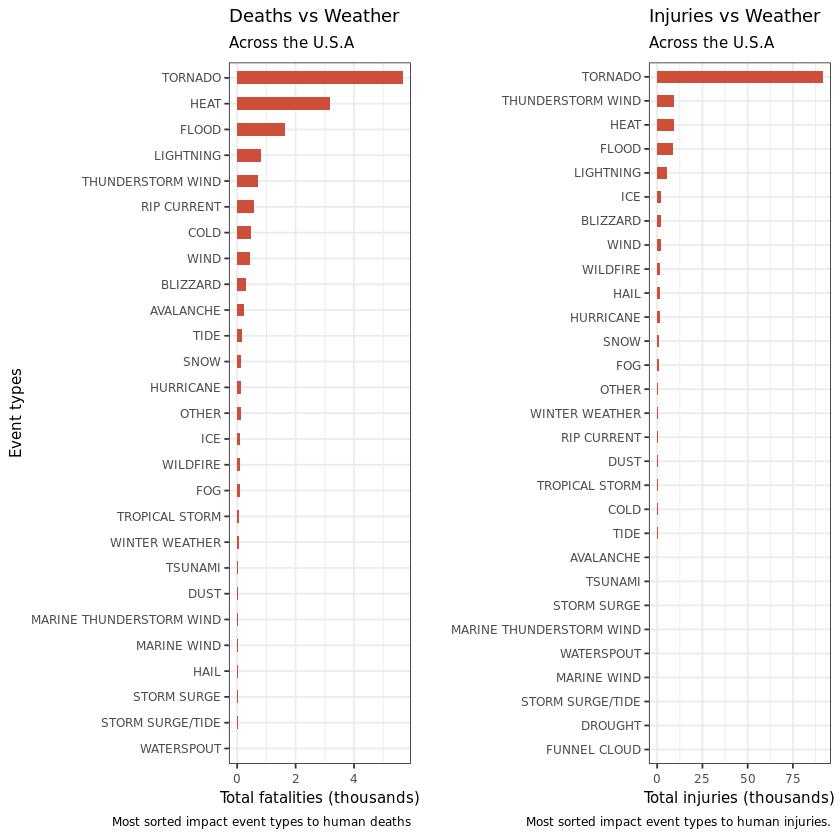

In [30]:
theme_set(theme_bw())

# Draw plot
g1 <- ggplot(b, aes(x=reorder(EVTYPE, FATALITIES), y=FATALITIES/1000)) +
  geom_bar(stat="identity", width=.5, fill="tomato3") +
  labs(title="Deaths vs Weather",
       subtitle="Across the U.S.A",
       y="Total fatalities (thousands)",
       x="Event types",
       caption = "Most sorted impact event types to human deaths") +
  coord_flip() +
  theme(text = element_text(size=9), axis.text.x = element_text(angle=0, vjust=0.6))

g2 <- ggplot(c, aes(x=reorder(EVTYPE, INJURIES), y=INJURIES/1000)) +
  geom_bar(stat="identity", width=.5, fill="tomato3") +
  labs(title="Injuries vs Weather",
       subtitle="Across the U.S.A",
       y="Total injuries (thousands)",
       x="",
       caption = "Most sorted impact event types to human injuries.") +
  coord_flip() +
  theme(text = element_text(size=9), axis.text.x = element_text(angle=0, vjust=0.6))

grid.arrange(arrangeGrob(g1,g2, ncol=2, nrow=1))

### **Discussions:**

It makes sense that the number of incurred injuries is much larger than deaths, roughly more than 10 times (>75,000 vs ~6,000), because injuries are easier to occur. The most 5 death impact events are: Tornado, Heat, Flood, Lightning and Thunderstorm wind. The most 5 injury impact events are Tornado, Thunderstorm wind, Heat, Flood and Lighting.

It is obvious that Tornado may be the strongest widest impact on human health, both deaths and injuries. Other types may have higher impact on either live lost or human injuries. For example, Thunderstorm wind tends to hurt rather than to kill people. Heat, Flood and Lightning are quite consistent towards public health.

More interestingly, Rip currents and Cold tend to kill human than just to make injuries. On the other hand, Ice and Hail tends to hurt than to kill people.

## 5.2. Events with most economic loss

To answer this question, we need to look at `PROPDMG`, its multiplier `PROPDMGEXP`, `CROPDMG`, its multiplier `CROPDMGEXP`. Let’s have a quick exam on the multiplier:

In [31]:
unique(dat$PROPDMGEXP)

[1] K M   B m + 0 5 6 ? 4 2 3 h 7 H - 1 8
Levels:  - ? + 0 1 2 3 4 5 6 7 8 B h H K m M

In [32]:
unique(dat$CROPDMGEXP)

[1]   M K m B ? 0 k 2
Levels:  ? 0 2 B k K m M


PROPDMGEXP and CROPDMGEXP both have some similar symbols (H,h,K,k,M,m,B,b,+,-,?,0,1,2,3,4,5,6,7,8, and blank-character). According to https://rstudio-pubs-static.s3.amazonaws.com/58957_37b6723ee52b455990e149edde45e5b6.html and https://github.com/flyingdisc/RepData_PeerAssessment2/blob/master/how-to-handle-PROPDMGEXP.md, I will fix them according to the multiply numbers below:
- H, h = hundreds = 100
- K, k = kilos = thousands = 1,000
- M, m = millions = 1,000,000
- B, b = billions = 1,000,000,000
- (+) = 1
- (-) = 0
- (?) = 0
- black/empty character = 0
- numeric 0..8 = 10

In order to reassign these variables, I first extract their 902,297 observations into `propdmgexp_fixed` and `cropdmgexp_fixed`:

In [33]:
propdmgexp_fixed <- as.character(dat$PROPDMGEXP)
cropdmgexp_fixed <- as.character(dat$CROPDMGEXP)

Then replace each symbol based on the rules above, for `propdmgexp_fixed`:

In [34]:
# Fix PROPDMG
propdmgexp_fixed[propdmgexp_fixed %in% c("H","h")] <- '100'
propdmgexp_fixed[propdmgexp_fixed %in% c("K")] <- '1000'
propdmgexp_fixed[propdmgexp_fixed %in% c("M","m")] <- '1000000'
propdmgexp_fixed[propdmgexp_fixed %in% c("B")] <- '1000000000'
propdmgexp_fixed[propdmgexp_fixed %in% c('0','1','2','3','4','5','6','7','8','9')] <- '10'
propdmgexp_fixed[propdmgexp_fixed == "+"] <- '1'
propdmgexp_fixed[propdmgexp_fixed == ""] <- '0'
propdmgexp_fixed[propdmgexp_fixed %in% c("-", "?")] <- '0'

and `cropdmgexp_fixed`:

In [35]:
# Fix CROPDMG
cropdmgexp_fixed[cropdmgexp_fixed %in% c("H","h")] <- '100'
cropdmgexp_fixed[cropdmgexp_fixed %in% c("K","k")] <- '1000'
cropdmgexp_fixed[cropdmgexp_fixed %in% c("M","m")] <- '1000000'
cropdmgexp_fixed[cropdmgexp_fixed %in% c("B")] <- '1000000000'
cropdmgexp_fixed[cropdmgexp_fixed %in% c('0','1','2','3','4','5','6','7','8','9')] <- '10'
cropdmgexp_fixed[cropdmgexp_fixed == "+"] <- '1'
cropdmgexp_fixed[cropdmgexp_fixed == ""] <- '0'
cropdmgexp_fixed[cropdmgexp_fixed %in% c("-", "?")] <- '0'

Now I can assign the fixed multipliers back to the data in new variables:

In [36]:
dat$PROPDMGEXP1 <- propdmgexp_fixed
dat$CROPDMGEXP1 <- cropdmgexp_fixed

The actual damage cost is calculated by multiplying the bases (`PROPDMG`, `CROPDMG`) with the fixed multipliers (`PROPDMGEXP1`, `CROPDMGEXP1`):

In [37]:
dat$PropDam <- as.numeric(dat$PROPDMG) * as.numeric(dat$PROPDMGEXP1)
dat$CropDam <- as.numeric(dat$CROPDMG) * as.numeric(dat$CROPDMGEXP1)

Similar to the previous question, I remove data with zero damage:

In [38]:
dat0propdam <- subset(dat,PropDam!=0)
dat0cropdam <- subset(dat,CropDam!=0)

and calculate the total damage cost with respect to each `EVTYPE`:

In [39]:
d <- aggregate(PropDam ~ EVTYPE, dat0propdam, sum)
e <- aggregate(CropDam ~ EVTYPE, dat0cropdam, sum)
d <- d[order(-d$PropDam),]
e <- e[order(-e$CropDam),]

and make a plot:

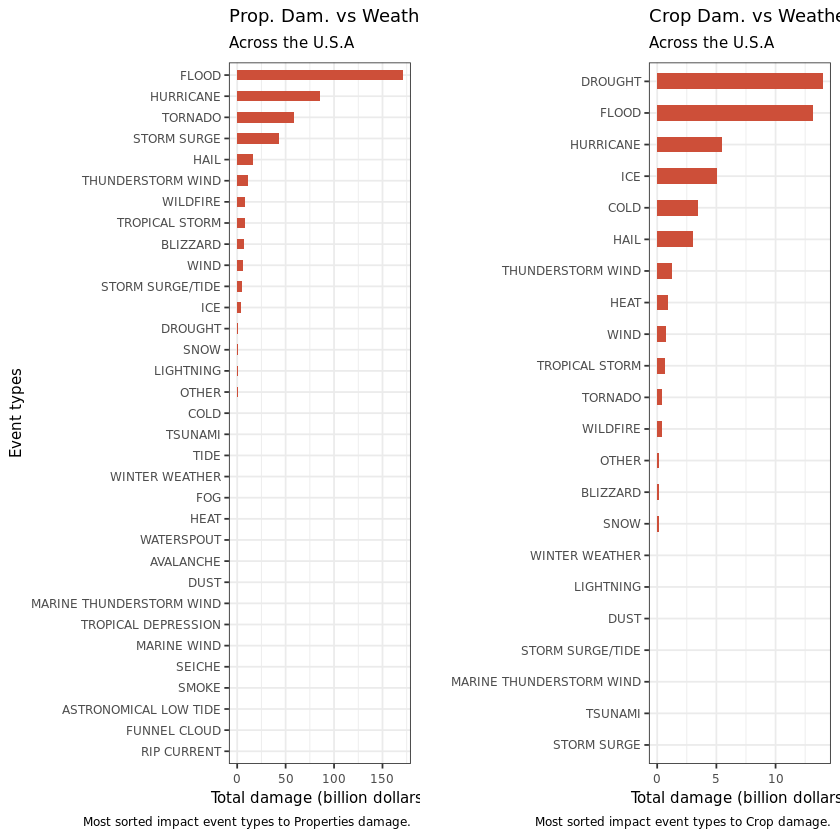

In [40]:
theme_set(theme_bw())

# Draw plot
g3 <- ggplot(d, aes(x=reorder(EVTYPE, PropDam), y=PropDam/1000000000)) +
  geom_bar(stat="identity", width=.5, fill="tomato3") +
  labs(title="Prop. Dam. vs Weather",
       subtitle="Across the U.S.A",
       y="Total damage (billion dollars)",
       x="Event types",
       caption = "Most sorted impact event types to Properties damage.") +
  coord_flip() +
  theme(text = element_text(size=9), axis.text.x = element_text(angle=0, vjust=0.6))

g4 <- ggplot(e, aes(x=reorder(EVTYPE, CropDam), y=CropDam/1000000000)) +
  geom_bar(stat="identity", width=.5, fill="tomato3") +
  labs(title="Crop Dam. vs Weather",
       subtitle="Across the U.S.A",
       y="Total damage (billion dollars)",
       x="",
       caption = "Most sorted impact event types to Crop damage.") +
  coord_flip() +
  theme(text = element_text(size=9), axis.text.x = element_text(angle=0, vjust=0.6))

grid.arrange(arrangeGrob(g3,g4, ncol=2, nrow=1))

### **Discussions:**

Damage in properties is much higher than in crops, roughly 10 times (>150 \\$B vs. 15 \\$B), which is reasonable because high-tech infrastructures are more expensive than farms. The most dangerous events damaging human properties are: Flood, Hurricane, Tornado, Storm surge and Hail. The most dangerous events effecting crops are: Drought, Flood, Hurricane, Ice and Cold.

It makes sense that different event types have different effects on the economy. For plants, Drough and Flood are the most serious problems. Hurricane, and Coldness are the next bad factors. For human properties, the 5 mentioned types have widest effects and can destroy human infrastructures, totally different from plant damage point of view. Ice, Drought and Cold obviously don’t have any effect on human properties.